In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# style -> white, dark, whitegrid, darkgrid, ticks
sns.set_style("darkgrid")

In [14]:
dados = pd.read_csv("../../dados/dados_tratados.csv", sep=';')
dados.head()

,unitTypes,usageTypes,usableAreas,totalAreas,bedrooms,bathrooms,parkingSpaces,suites,longitude,latitude,zone,neighborhood,yearlyIptu,monthlyCondoFee,price
0,RESIDENTIAL_ALLOTMENT_LAND,RESIDENTIAL,150.0,150.0,0.0,0.0,0.0,0.0,-43.704318,-22.906731,Zona Oeste,Santa Cruz,0.0,0.0,3500
1,APARTMENT,RESIDENTIAL,42.0,42.0,2.0,1.0,0.0,0.0,-43.203115,-22.896929,Zona Central,Santo Cristo,100.0,400.0,18500
2,APARTMENT,RESIDENTIAL,53.0,53.0,2.0,3.0,2.0,2.0,-43.173045,-22.924791,Zona Sul,Flamengo,NaN,NaN,18000
3,PARKING_SPACE,COMMERCIAL,12.0,12.0,0.0,0.0,1.0,NaN,-43.178923,-22.965244,Zona Sul,Copacabana,116.0,300.0,20000
4,APARTMENT,RESIDENTIAL,42.0,NaN,1.0,1.0,NaN,0.0,-43.222759,-22.888793,Zona Norte,São Cristóvão,110.0,300.0,15000


### Removendo os dados nulos

In [15]:
dados_sem_nulos = dados[~dados.isna().any(axis=1)].reset_index(drop=True)
dados_sem_nulos.head()

,unitTypes,usageTypes,usableAreas,totalAreas,bedrooms,bathrooms,parkingSpaces,suites,longitude,latitude,zone,neighborhood,yearlyIptu,monthlyCondoFee,price
0,RESIDENTIAL_ALLOTMENT_LAND,RESIDENTIAL,150.0,150.0,0.0,0.0,0.0,0.0,-43.704318,-22.906731,Zona Oeste,Santa Cruz,0.0,0.0,3500
1,APARTMENT,RESIDENTIAL,42.0,42.0,2.0,1.0,0.0,0.0,-43.203115,-22.896929,Zona Central,Santo Cristo,100.0,400.0,18500
2,APARTMENT,RESIDENTIAL,47.0,47.0,2.0,2.0,0.0,1.0,-43.200767,-22.895467,Zona Central,Santo Cristo,189.0,499.0,16000
3,APARTMENT,RESIDENTIAL,42.0,42.0,2.0,1.0,0.0,0.0,-43.202808,-22.897015,Zona Central,Santo Cristo,100.0,400.0,16400
4,APARTMENT,RESIDENTIAL,41.0,41.0,2.0,1.0,1.0,0.0,-43.593790,-22.883163,Zona Oeste,Campo Grande,0.0,0.0,19000


vamos remover a coluna `totalAreas`, `latitude` e `longitude`

In [16]:
dados_sem_nulos.corr()

,usableAreas,totalAreas,bedrooms,bathrooms,parkingSpaces,suites,longitude,latitude,yearlyIptu,monthlyCondoFee,price
usableAreas,1.000000,0.858766,-0.008822,-0.006354,-0.003240,-0.003860,-0.007127,-0.002179,-0.000029,-0.000197,0.003119
totalAreas,0.858766,1.000000,-0.008103,-0.006021,-0.003264,-0.001919,-0.008179,0.000771,-0.000097,-0.000369,0.001516
bedrooms,-0.008822,-0.008103,1.000000,0.660523,0.348404,0.612089,-0.103439,-0.196392,0.014895,0.012654,0.491046
bathrooms,-0.006354,-0.006021,0.660523,1.000000,0.414404,0.750085,-0.160109,-0.264892,0.010855,0.015820,0.565877
parkingSpaces,-0.003240,-0.003264,0.348404,0.414404,1.000000,0.399872,-0.193805,-0.161440,0.004951,0.012116,0.374547
...,...,...,...,...,...,...,...,...,...,...,...
longitude,-0.007127,-0.008179,-0.103439,-0.160109,-0.193805,-0.239196,1.000000,0.320505,0.008567,0.011719,0.103806
latitude,-0.002179,0.000771,-0.196392,-0.264892,-0.161440,-0.339950,0.320505,1.000000,-0.002983,-0.018595,-0.354410
yearlyIptu,-0.000029,-0.000097,0.014895,0.010855,0.004951,0.022478,0.008567,-0.002983,1.000000,0.133830,0.022566
monthlyCondoFee,-0.000197,-0.000369,0.012654,0.015820,0.012116,0.016164,0.011719,-0.018595,0.133830,1.000000,0.036572


In [17]:
dados_final = dados_sem_nulos.drop(['totalAreas', 'latitude', 'longitude'], axis=1)
dados_final.head()

,unitTypes,usageTypes,usableAreas,bedrooms,bathrooms,parkingSpaces,suites,zone,neighborhood,yearlyIptu,monthlyCondoFee,price
0,RESIDENTIAL_ALLOTMENT_LAND,RESIDENTIAL,150.0,0.0,0.0,0.0,0.0,Zona Oeste,Santa Cruz,0.0,0.0,3500
1,APARTMENT,RESIDENTIAL,42.0,2.0,1.0,0.0,0.0,Zona Central,Santo Cristo,100.0,400.0,18500
2,APARTMENT,RESIDENTIAL,47.0,2.0,2.0,0.0,1.0,Zona Central,Santo Cristo,189.0,499.0,16000
3,APARTMENT,RESIDENTIAL,42.0,2.0,1.0,0.0,0.0,Zona Central,Santo Cristo,100.0,400.0,16400
4,APARTMENT,RESIDENTIAL,41.0,2.0,1.0,1.0,0.0,Zona Oeste,Campo Grande,0.0,0.0,19000


In [18]:
dados_final.describe().round(2)

,usableAreas,bedrooms,bathrooms,parkingSpaces,suites,yearlyIptu,monthlyCondoFee,price
count,57354.00,57354.00,57354.00,57354.00,57354.00,57354.0,57354.00,57354.00
mean,1555.34,2.73,2.58,1.55,1.25,5929.0,3610.44,1461021.33
std,329109.35,1.27,1.63,1.85,1.26,368204.0,75797.22,1595741.43
min,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3500.00
25%,70.00,2.00,1.00,1.00,0.00,80.0,450.00,470000.00
50%,100.00,3.00,2.00,1.00,1.00,413.0,880.00,857814.00
75%,179.00,3.00,3.00,2.00,2.00,1600.0,1500.00,1800000.00
max,78816375.00,50.00,50.00,180.00,50.00,75122000.0,5300000.00,10000000.00


### Construindo as visualizações

> Histograma

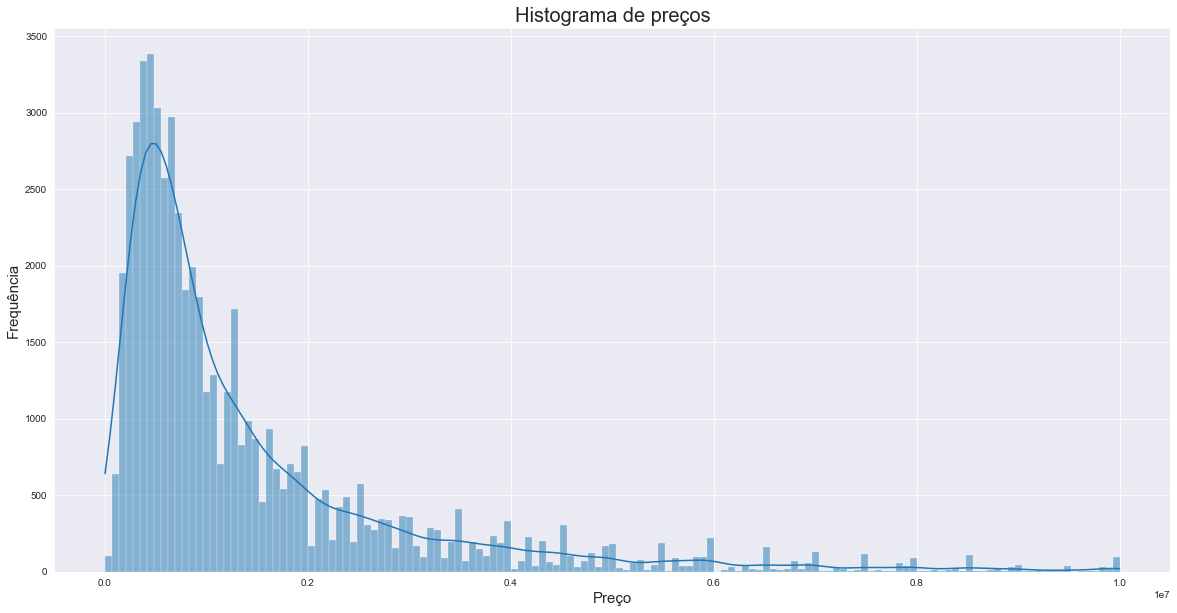

In [19]:
ax = sns.histplot(data=dados_final, x='price', kde=True)
ax.figure.set_size_inches(20, 10)
ax.set_title('Histograma de preços', fontsize=20)
ax.set_xlabel('Preço', fontsize=15)
ax.set_ylabel('Frequência', fontsize=15);

Analisando a distribuição da variável target percebemos que é uma curva assimétrica a direita. Era de se esperar que obtivessemos uma curva com essa característica pois a distribuição do preço do imóvel segue a mesma lógica que a distribuição de renda, há muitos imóveis com preços baixos e poucos imóveis com preços exorbitantes. Estatisticamente teríamos:

![](https://i.imgur.com/ADdCEWx.png)

Moda < Mediana < média

> Boxplot

<AxesSubplot:title={'center':'Preço dos imóveis'}, ylabel='Preço'>

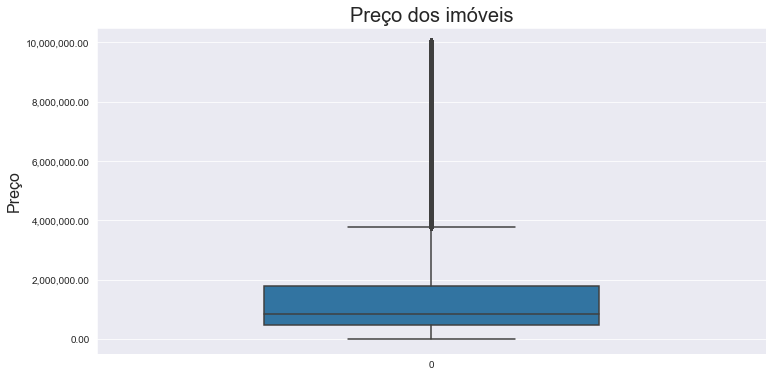

In [20]:
import matplotlib.ticker as ticker

ax = sns.boxplot(data=dados_final['price'], orient='v', width=0.5)
ax.figure.set_size_inches(12, 6)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_title('Preço dos imóveis', fontsize=20)
ax.set_ylabel('Preço', fontsize=16)
ax

Considerar esses dados atipicos como outliers e remove-los pode ser um erro, realizar uma transformação de variável seria o mais adequado,principalmente porque de acordo com esse Boxplot, a variável target não é uma distribuição normal. 

Vamos analisar como o preço se comporta de acordo com algumas variáveis categóricas.

* Utilizando boxplot com duas variáveis

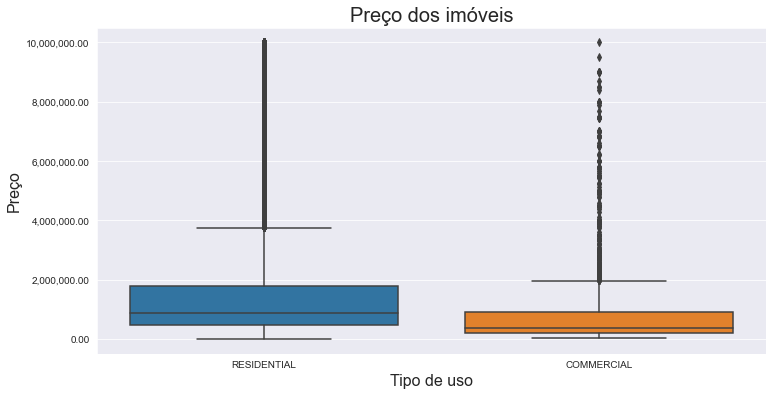

In [21]:
ax = sns.boxplot(data=dados_final, x='usageTypes', y='price')
ax.figure.set_size_inches(12, 6)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_title('Preço dos imóveis', fontsize=20)
ax.set_ylabel('Preço', fontsize=16)
ax.set_xlabel('Tipo de uso', fontsize=16);


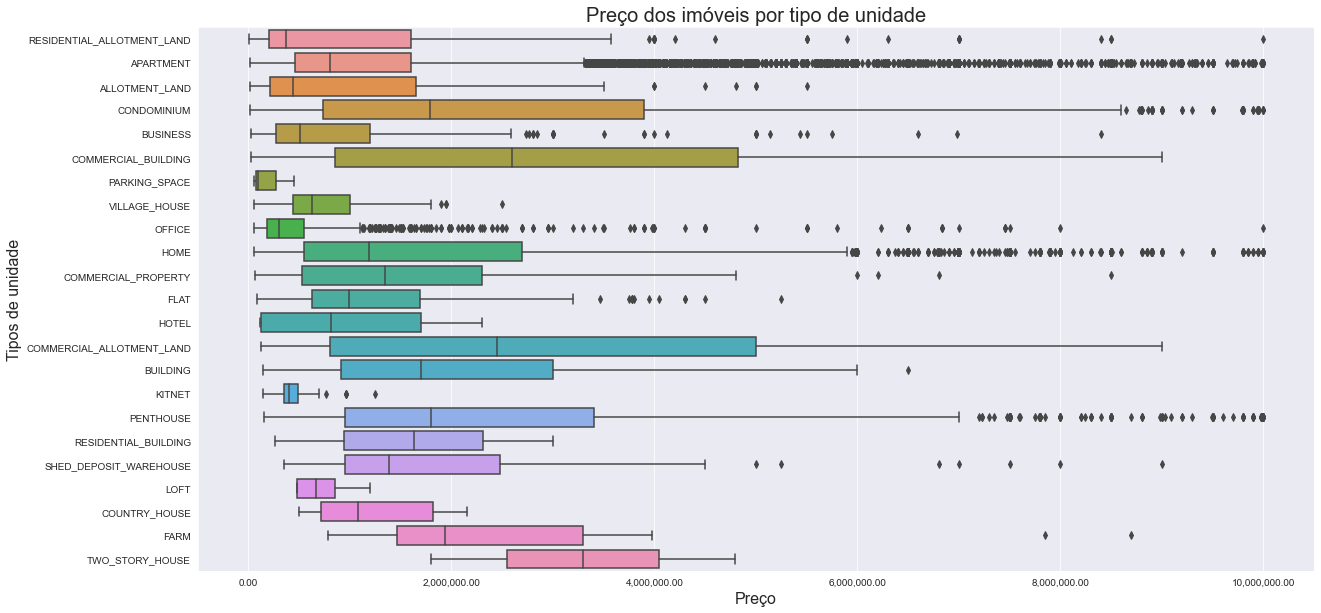

In [22]:
ax = sns.boxplot(data=dados_final, y='unitTypes', x='price', orient='h')
ax.figure.set_size_inches(20, 10)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_title('Preço dos imóveis por tipo de unidade', fontsize=20)
ax.set_ylabel('Tipos de unidade', fontsize=16)
ax.set_xlabel('Preço', fontsize=16);

## Criando visualizações para as variáveis categóricas:

In [25]:
# Quais são as variáveis categóricas?

dados_final.select_dtypes(include=['object']).columns

Index(['unitTypes', 'usageTypes', 'zone', 'neighborhood'], dtype='object')

Vamos primeiro verificar como estão distribuídos os tipos de imoveis

In [26]:
def plot_countplot_categorical_variable(variable, dataframe, title, xlabel):
    plt.figure(figsize=(12, 6))
    ax = dataframe[variable].value_counts().plot(kind='bar')
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Quantidade', fontsize=16)
    for container in ax.containers:
        ax.bar_label(container, fontsize=12)


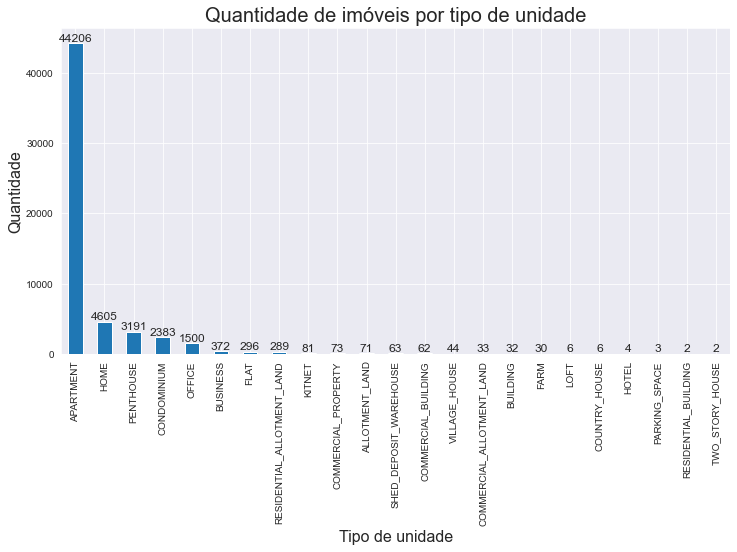

In [27]:
plot_countplot_categorical_variable(variable='unitTypes', dataframe=dados_final, 
                                    title='Quantidade de imóveis por tipo de unidade', xlabel='Tipo de unidade')

Percebe-se que há muito mais imoveis de apartamentos para serem vendidos do que qualquer outro tipo. 

Agora vamos analisar a distribuição do preço médio de cada tipo de imovel:

In [28]:
def plot_barplot_average_price(variable, dataframe, title, xlabel, ylabel, figsize=(20,10)):
    ax = sns.barplot(data=dataframe, y=variable, x='price', orient='h', palette="Blues_d", 
                    order=dataframe.groupby(variable).price.mean().sort_values(ascending=False).index)
    ax.figure.set_size_inches(figsize)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16);

In [30]:
print(f"Quantidade de tipos de unidade: {len(dados_final.unitTypes.unique())}")

Quantidade de tipos de unidade: 23


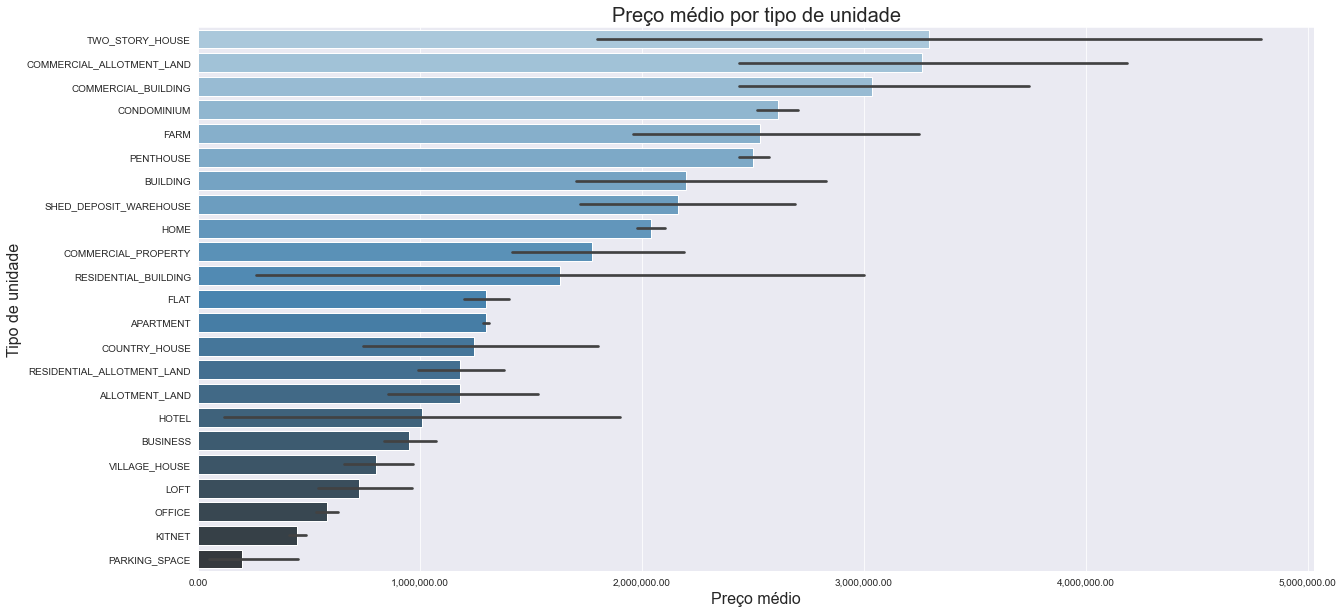

In [31]:
plot_barplot_average_price(variable='unitTypes', dataframe=dados_final, 
                           title='Preço médio por tipo de unidade', xlabel='Preço médio', ylabel='Tipo de unidade')

Pelo gráfico acima podemos perceber que as casas com dois andares são as que apresentam um maior preço médio, o que apresentam menor preço médio é o espaço para estacionamento. Provavelmente é um espaço destinado unicamente para estacionamento, ou está sendo vendido somente a vaga para estacionar, portanto faz total sentido que seja mais barato.

Vamos construir a mesma analise feita anteriormente para os tipos de uso:


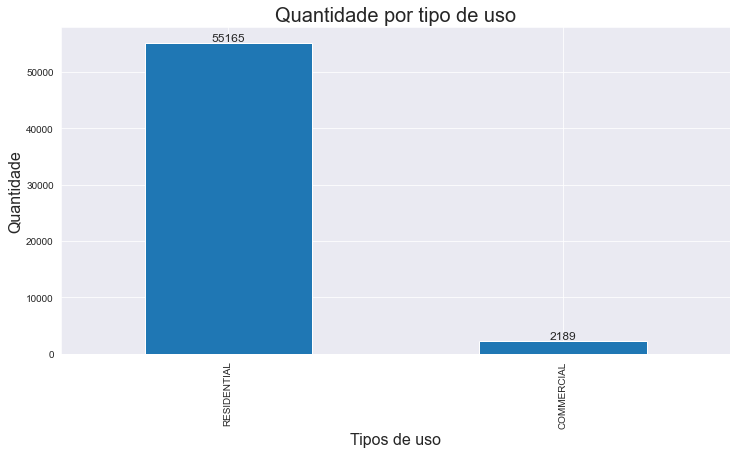

In [32]:
plot_countplot_categorical_variable(variable='usageTypes', dataframe=dados_final, 
                                    title='Quantidade por tipo de uso', xlabel='Tipos de uso')

No conjunto de dados há poucos imoveis destinados a uso comercial represetando apenas 3.82% da quantidade de imóveis vendidos presente na base de daods.

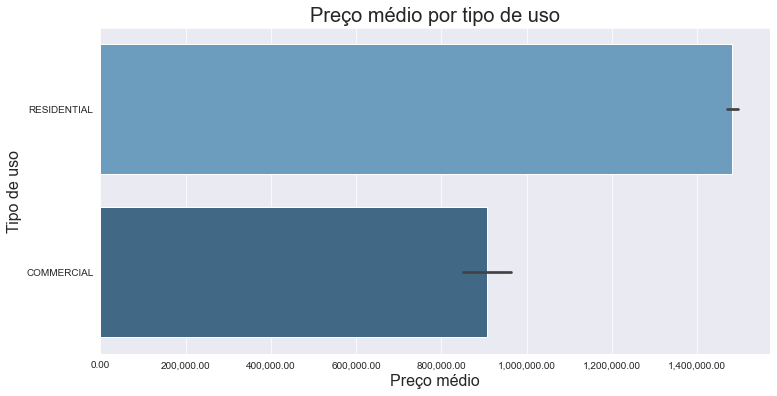

In [33]:
plot_barplot_average_price(variable='usageTypes', dataframe=dados_final, 
                           title='Preço médio por tipo de uso', xlabel='Preço médio', 
                           ylabel='Tipo de uso', figsize=(12, 6))

Residencial portanto possui um preço em média um preço maior que os imoveis destinados a uso comercial. 

Vamos analisar por zona agora:


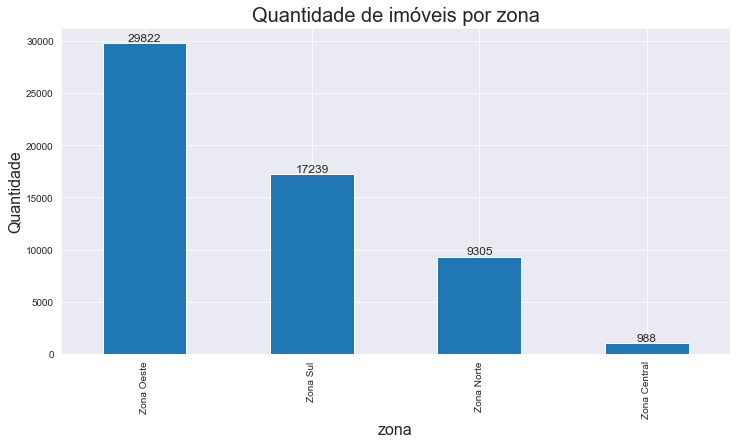

In [35]:
plot_countplot_categorical_variable(variable='zone', dataframe=dados_final, 
                                    title='Quantidade de imóveis por zona', xlabel='zona')

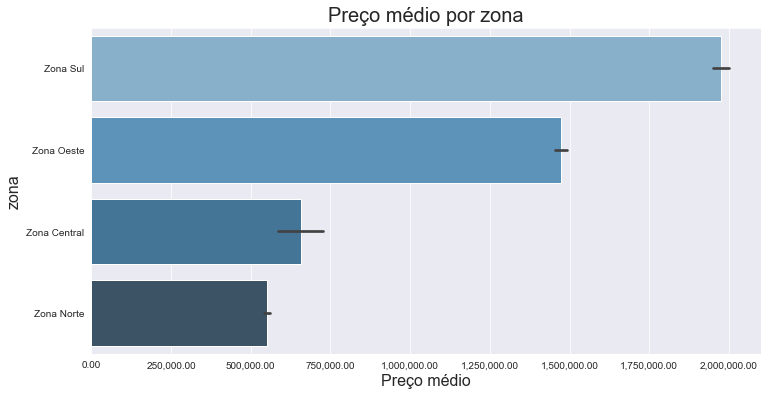

In [19]:
plot_barplot_average_price(variable='zone', dataframe=dados_final, 
                           title='Preço médio por zona', xlabel='Preço médio', 
                           ylabel='zona', figsize=(12, 6))

Percebe-se que a zona mais "rica" do Rio de Janeiro de acordo com nosso conjunto de dados. Será se isso condiz com a realidade? de acordo com o artigo [Conheça 13 bairros nobres do RJ e o que tem de mais legal em cada um](https://blog.loft.com.br/bairros-nobres-do-rj/): 

> Não é à toa que cinco dos bairros mais caros do país estão localizados na Zona Sul carioca, sendo eles o Leblon, Ipanema, Lagoa, Gávea e Jardim Botânico.

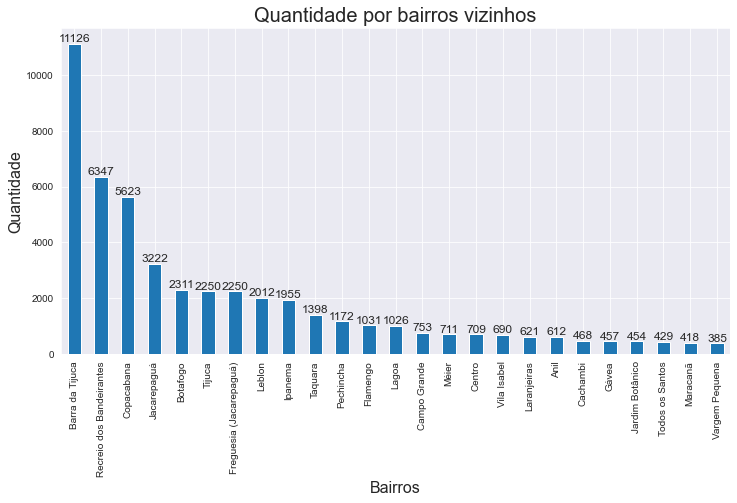

In [20]:
plt.figure(figsize=(12, 6))
ax = dados_final['neighborhood'].value_counts().head(25).plot(kind='bar')
plt.title('Quantidade por bairros vizinhos', fontsize=20)
plt.xlabel('Bairros', fontsize=16)
plt.ylabel('Quantidade', fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

In [21]:
dados_final.groupby('neighborhood').price.mean().sort_values(ascending=False).index[:10]

Index(['Barros Filho', 'Joá', 'Ricardo de Albuquerque', 'Lagoa', 'Leblon',
       'Ipanema', 'Urca', 'Itanhangá', 'São Conrado', 'Barra da Tijuca'],
      dtype='object', name='neighborhood')

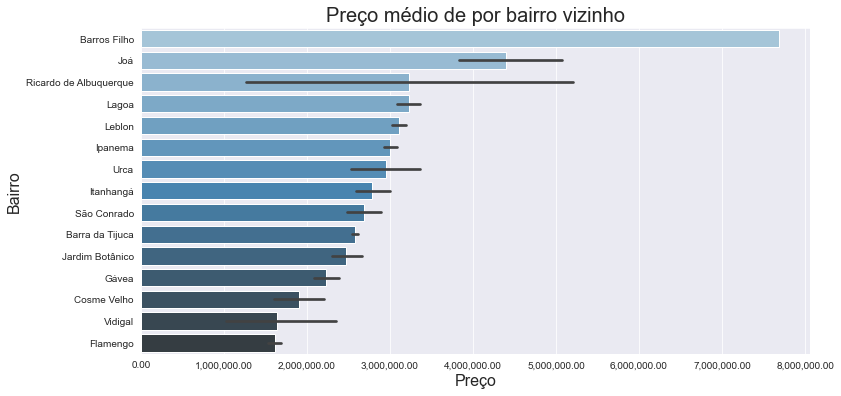

In [22]:
ax = sns.barplot(data=dados_final, y='neighborhood', x='price', orient='h', palette="Blues_d", 
                order=dados_final.groupby('neighborhood').price.mean().sort_values(ascending=False).index[:15])
ax.figure.set_size_inches(12, 6)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_title('Preço médio de por bairro vizinho', fontsize=20)
ax.set_ylabel('Bairro', fontsize=16)
ax.set_xlabel('Preço', fontsize=16);

Percebe-se pela linha de que representa o invervalo de confiança que essa análise não é válida, visto que há poucas amostras para alguns bairros vizinhos, como por exemplo "Ricardo de Alburquerque" e mais claramente "Barros filho" que nem possui a linha de confiança, pois há somente uma amostra. 

## Analisando a relação das variáveis com a variável target

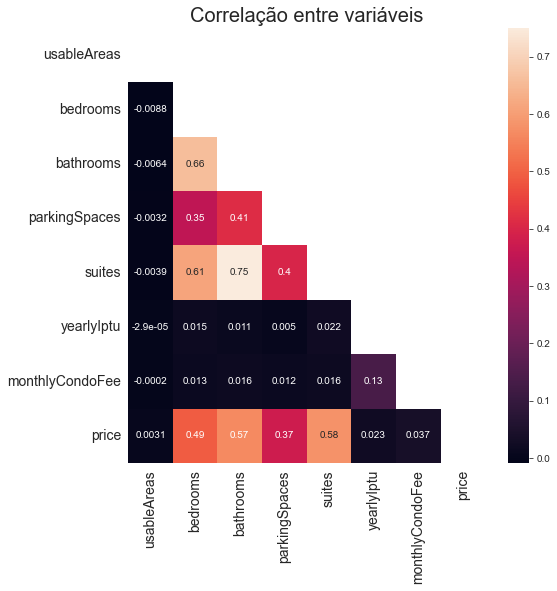

In [36]:
corr = dados_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr, mask=mask, fmt=".2",  annot=True)
    ax.tick_params(labelsize=14)
    ax.set_title('Correlação entre variáveis', fontsize=20)

Não há variaveis que são muito correlacionadas.

In [24]:
dados_final.select_dtypes(exclude=['object']).drop('price', axis=1).columns

Index(['usableAreas', 'bedrooms', 'bathrooms', 'parkingSpaces', 'suites',
       'yearlyIptu', 'monthlyCondoFee'],
      dtype='object')

> Pairplot

Text(0.5, 1.1, 'Regressão Linear')

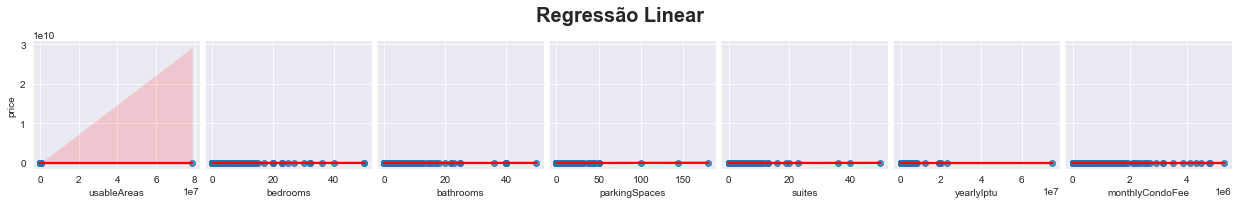

In [25]:
ax = sns.pairplot(dados_final, y_vars=['price'], 
             x_vars=dados_final.select_dtypes(exclude=['object']).drop('price', axis=1).columns, kind='reg',
             plot_kws={'line_kws':{'color':'red'}})

ax.fig.suptitle('Regressão Linear', fontsize=20, fontweight='bold',  y=1.1)

Da forma que está não conseguimos visualizar a relação entre as variáveis. Vamos fazer a transformação logaritmica pois:

> "Testes paramétricos assumem que os dados amostrais foram coletados de uma população com distribuição de probabilidade conhecida. Boa parte dos testes estatísticos assumem que os dados seguem uma distribuição normal"

In [37]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p, validate=True)

In [38]:
dados_transformados = transformer.transform(dados_final.select_dtypes(exclude=['object']))
colunas_dados_tranformados = dados_final.select_dtypes(exclude=['object']).columns

In [39]:
df_transformado = pd.concat([dados_final.select_dtypes(include=['object']), pd.DataFrame(dados_transformados, columns=colunas_dados_tranformados)], axis=1)
df_transformado.head()

,unitTypes,usageTypes,zone,neighborhood,usableAreas,bedrooms,bathrooms,parkingSpaces,suites,yearlyIptu,monthlyCondoFee,price
0,RESIDENTIAL_ALLOTMENT_LAND,RESIDENTIAL,Zona Oeste,Santa Cruz,5.017280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.160804
1,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,3.761200,1.098612,0.693147,0.000000,0.000000,4.615121,5.993961,9.825580
2,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,3.871201,1.098612,1.098612,0.000000,0.693147,5.247024,6.214608,9.680406
3,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,3.761200,1.098612,0.693147,0.000000,0.000000,4.615121,5.993961,9.705098
4,APARTMENT,RESIDENTIAL,Zona Oeste,Campo Grande,3.737670,1.098612,0.693147,0.693147,0.000000,0.000000,0.000000,9.852247


Text(0.5, 1.1, 'Regressão Linear')

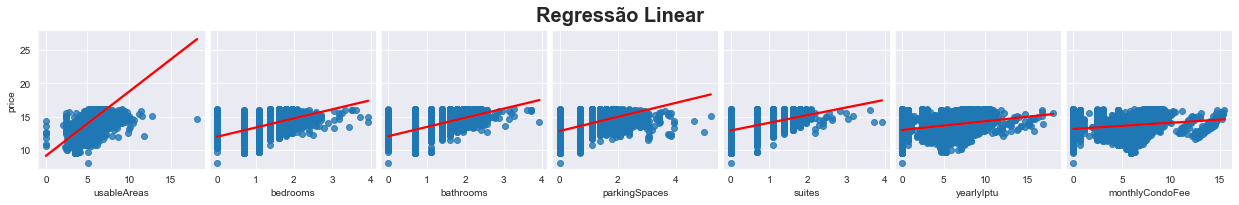

In [29]:
ax = sns.pairplot(df_transformado, y_vars=['price'], 
             x_vars=df_transformado.select_dtypes(exclude=['object']).drop('price', axis=1).columns, kind='reg',
             plot_kws={'line_kws':{'color':'red'}})

ax.fig.suptitle('Regressão Linear', fontsize=20, fontweight='bold',  y=1.1)

OBS: Testar posteriormente o [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) para realizar essas transformações.


Agora podemos perceber que há algumas relações lineares entre a variável target e variáveis explicativas. As variáveis `monthlyCondoFee` e `yearlyIptu` é praticamente constante, então essa variável provavelmente não vai ter muita importância na construção do modelo de regressão linear, porém para outros modelos, como de arvore de regressão essa variável pode ser importante. Vamos deixa-la a principio. 

Vamos analisar como está a distribuição da variável target:


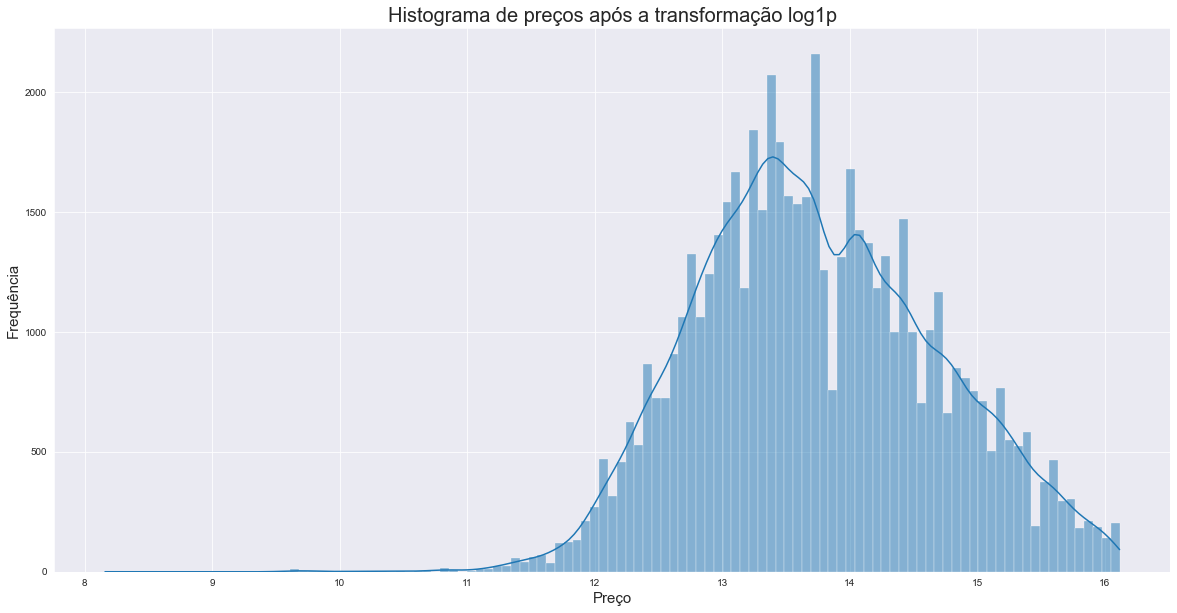

In [41]:
ax = sns.histplot(data=df_transformado, x='price', kde=True)
ax.figure.set_size_inches(20, 10)
ax.set_title('Histograma de preços após a transformação log1p', fontsize=20)
ax.set_xlabel('Preço', fontsize=15)
ax.set_ylabel('Frequência', fontsize=15);

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dados_final.select_dtypes(exclude=['object']))
dados_transformados_sc = scaler.transform(dados_final.select_dtypes(exclude=['object']))
colunas_dados_tranformados_sc = dados_final.select_dtypes(exclude=['object']).columns
df_transformado = pd.concat([dados_final.select_dtypes(include=['object']), pd.DataFrame(dados_transformados_sc, columns=colunas_dados_tranformados_sc)], axis=1)
df_transformado.head()

StandardScaler()


,unitTypes,usageTypes,zone,neighborhood,usableAreas,bedrooms,bathrooms,parkingSpaces,suites,yearlyIptu,monthlyCondoFee,price
0,RESIDENTIAL_ALLOTMENT_LAND,RESIDENTIAL,Zona Oeste,Santa Cruz,-0.004270,-2.155159,-1.584789,-0.839399,-0.98735,-0.016103,-0.047633,-0.913390
1,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,-0.004598,-0.574285,-0.969743,-0.839399,-0.98735,-0.015831,-0.042356,-0.903990
2,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,-0.004583,-0.574285,-0.354697,-0.839399,-0.19603,-0.015589,-0.041050,-0.905556
3,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,-0.004598,-0.574285,-0.969743,-0.839399,-0.98735,-0.015831,-0.042356,-0.905306
4,APARTMENT,RESIDENTIAL,Zona Oeste,Campo Grande,-0.004601,-0.574285,-0.969743,-0.299275,-0.98735,-0.016103,-0.047633,-0.903676


Ter uma distribuição normal seria praticamente impossível, mas percebe-se que curva se aproximou mais da normal.

### Variáveis dummies

In [31]:
df_transformado

,unitTypes,usageTypes,zone,neighborhood,usableAreas,bedrooms,bathrooms,parkingSpaces,suites,yearlyIptu,monthlyCondoFee,price
0,RESIDENTIAL_ALLOTMENT_LAND,RESIDENTIAL,Zona Oeste,Santa Cruz,5.017280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.160804
1,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,3.761200,1.098612,0.693147,0.000000,0.000000,4.615121,5.993961,9.825580
2,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,3.871201,1.098612,1.098612,0.000000,0.693147,5.247024,6.214608,9.680406
3,APARTMENT,RESIDENTIAL,Zona Central,Santo Cristo,3.761200,1.098612,0.693147,0.000000,0.000000,4.615121,5.993961,9.705098
4,APARTMENT,RESIDENTIAL,Zona Oeste,Campo Grande,3.737670,1.098612,0.693147,0.693147,0.000000,0.000000,0.000000,9.852247
...,...,...,...,...,...,...,...,...,...,...,...,...
57349,HOME,RESIDENTIAL,Zona Oeste,Barra da Tijuca,6.922644,1.791759,1.945910,1.791759,1.791759,10.098972,7.772332,16.118096
57350,HOME,RESIDENTIAL,Zona Oeste,Barra da Tijuca,6.932448,1.791759,2.397895,1.609438,0.693147,7.972811,7.762596,16.118096
57351,HOME,RESIDENTIAL,Zona Oeste,Barra da Tijuca,6.621406,1.791759,2.079442,1.945910,1.791759,9.615872,8.006701,16.118096
57352,HOME,RESIDENTIAL,Zona Oeste,Barra da Tijuca,6.932448,1.791759,2.397895,1.609438,1.791759,10.463132,7.783641,16.118096


In [34]:
df_transformado.drop('neighborhood', axis=1, inplace=True)  # dropar isso no inicio

*Motivo para ter dropado:*

![](https://i.imgur.com/ITBYQet.png)
![](https://i.imgur.com/qXPewVE.png)
    

In [36]:
colunas_categoricas = df_transformado.select_dtypes(include=['object']).columns
colunas_categoricas

Index(['unitTypes', 'usageTypes', 'zone'], dtype='object')

In [49]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='error', dtype=int)

colunas_ohe = ohe.fit_transform(df_transformado[colunas_categoricas]).toarray()

dados_ohe = pd.concat([df_transformado.drop(colunas_categoricas, axis=1), pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names(colunas_categoricas))], axis=1)
dados_ohe.head()

,usableAreas,bedrooms,bathrooms,parkingSpaces,suites,yearlyIptu,monthlyCondoFee,price,unitTypes_ALLOTMENT_LAND,unitTypes_APARTMENT,...,unitTypes_RESIDENTIAL_BUILDING,unitTypes_SHED_DEPOSIT_WAREHOUSE,unitTypes_TWO_STORY_HOUSE,unitTypes_VILLAGE_HOUSE,usageTypes_COMMERCIAL,usageTypes_RESIDENTIAL,zone_Zona Central,zone_Zona Norte,zone_Zona Oeste,zone_Zona Sul
0,5.017280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.160804,0,0,...,0,0,0,0,0,1,0,0,1,0
1,3.761200,1.098612,0.693147,0.000000,0.000000,4.615121,5.993961,9.825580,0,1,...,0,0,0,0,0,1,1,0,0,0
2,3.871201,1.098612,1.098612,0.000000,0.693147,5.247024,6.214608,9.680406,0,1,...,0,0,0,0,0,1,1,0,0,0
3,3.761200,1.098612,0.693147,0.000000,0.000000,4.615121,5.993961,9.705098,0,1,...,0,0,0,0,0,1,1,0,0,0
4,3.737670,1.098612,0.693147,0.693147,0.000000,0.000000,0.000000,9.852247,0,1,...,0,0,0,0,0,1,0,0,1,0


### Salvando os dados para serem utilizados no modelo:



In [50]:
dados_ohe.to_csv('../../dados/dados_OneHotEncoder.csv', index=False)